# Forcasting Using Seasonal ARIMA (SARIMA) 

Time series forecasting is the use of a model to predict future values based on previously observed values. 

In [29]:
%config IPCompleter.greedy=True
%matplotlib inline  

import pandas as pd
import numpy as np
from numpy import array
import datetime
import statsmodels.api as sm  
import matplotlib.pyplot as plt
import itertools

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from scripts.data import deutsches_wetterdienst
from scripts.grid import grid_search

## Load Official Weather Data Observations

readings every hour

In [53]:
df = deutsches_wetterdienst('/Users/stewarta/Documents/DATA/htsensor/produkt_tu_stunde_19510101_20171231_00662.txt')
df.head()

,Temp,Humi
datetime,,
2013-01-01 00:00:00,8.4,70.0
2013-01-01 01:00:00,8.4,70.0
2013-01-01 02:00:00,8.4,69.0
2013-01-01 03:00:00,8.7,68.0
2013-01-01 04:00:00,8.5,69.0


In [54]:
# compute daily average : fill in nans created during resampling with the nearest value
timestep = 'D'
df = df.resample(timestep).mean().ffill()
df.head()

,Temp,Humi
datetime,,
2013-01-01,6.658333,81.000000
2013-01-02,5.354167,83.541667
2013-01-03,7.995833,92.083333
2013-01-04,8.958333,92.458333
2013-01-05,7.554167,97.458333


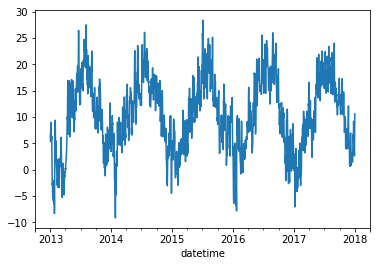

In [55]:
# select single variable for building model
sensor = 'Temp'
df[sensor].plot()

## SARIMA Hyperparameters

The data contains cycles so lets model it using SARIMA

SARIMA model, SARIMA(p,d,q)(P,D,Q)[m] has hyperparameters that control the nature of the model performed for the series, trend and seasonality, they are:

* order: (p,d,q) A tuple p, d, and q parameters for the modeling of the trend.
* sesonal_order: (P,D,Q)[m] A tuple of P, D, Q, and m parameters for the modeling the seasonality

We can select these hyperparameters in two ways: 

* Automated Hyperparameter Selection using Grid Search
* Manual Hyperparameter Selection using ACF / PACF Plots

## Automated Hyperparameter Selection using Grid Search

Grid search is used to help us select hyperparameters. In a grid search, we train and evaluate a model on all possible configurations of the hyperparameters. If you have many models to build automating the hyperparameter selection will save time.

However, depending on computing resources, grid search make take a while when if your search space is large. 


### Parsimony Principle

Rules of thumb exist to help constrain the value of the hyperparameter and avoid  building overly complex models. One rule for SARIMA is the Parsimony Principle in which sum of hyperparameter values: p+d+q+P+D+Q ≤ 6. 

In [6]:
def sarima_configs(seasonal=[12]):
    models = list()
    # define config lists
    p = [0, 1]
    d = [0]
    q = [0, 1]
    t = ['c','n']
    P = [0, 1]
    D = [0, 1]
    Q = [0, 1]
    m = seasonal   
    
    # create combinations of the hyperparameters
    non_seasonal = itertools.product(p, d, q)
    seasonal = itertools.product(P, D, Q, m)
    result = []
    for tup in itertools.product(non_seasonal, seasonal, t):
        result.append(list(tup))
    return result           

configs = sarima_configs()
print('The number of SARIMA hyperparameter configurations is: {}'.format(len(configs)))

The number of SARIMA hyperparameter configurations is: 64


## Grid Search 
Use subset of the data for training and the last 'lookahead' elements of the the training set for  hyperparameter evaluation.

Each configuration of the hyperparameter is evaluated using 'lookahead' steps beyond original training set.  We incrementally train a model and  make a forecast for a timestep that is one time step ahead. 

After a timestep is used to evaluate a prediction it is incorporated into the training set. Performance is recored for each hyperparameter configuration for each lookahead and the best performing configuration is used for building the final model.

In [ ]:
# NOTE: Peforming Grid Search may take a while to run, depending the number of parameters

## prepare data for grid search
data = np.array(df[sensor])
print('The number of observations are: {} '.format(len(data)))

minidx = df.index.get_loc('2013-01-01')
maxidx = df.index.get_loc('2014-03-15')
lookahead_validation = 20
trainval = data[minidx:maxidx] 

# perform grid search
scores = grid_search(trainval, configs, lookahead_validation)
print('done')

# list top 3 hyperparameter configs
for cfg, error in scores[:3]:
    print(cfg, error)

# Train a SARIMA Model

Once you have selected your hyperparameters, you can set the arguments for the SARIMAX and build a model.

Let's build a model using the hyperparameters below on a subset of the data.

In [44]:
# data subset boundaries
mindate = '2013-01-01'
maxdate = '2014-01-15'

# create a subset for training 
traindata = df['Temp'].loc[mindate:maxdate]

# build the model
sarima = sm.tsa.statespace.SARIMAX(traindata,trend='c', order=(0,0,1), seasonal_order=(1,0,1,2) )
model = sarima.fit(disp=True)

## Forecast Future Values

We can make multistep forecast using the predict() function.

predict(): In-sample prediction and out-of-sample forecasting

In [48]:
# Making a Prediction

# find location last idx of training data
idx = len(traindata)
predictions = model.predict(start=idx-5, end=idx + 20) 

# create dataframe of predictions. 
df_predictions = pd.DataFrame(predictions, columns=['Prediction'])
print('The predictions are:')
df_predictions

The predictions are:


,Prediction
2013-08-31,15.648783
2013-09-30,16.796786
2013-10-31,12.458086
2013-11-30,8.240320
2013-12-31,3.429286
2014-01-31,5.790845
2014-02-28,6.916137
2014-03-31,9.014719
2014-04-30,7.922043
2014-05-31,8.463023


# Prediction Results

In [49]:
df['Prediction'] = pd.DataFrame(df_predictions)
df.head()

,Temp,Humi,Prediction
datetime,,,
2013-01-31,0.627957,88.754032,NaN
2013-02-28,0.075149,88.358631,NaN
2013-03-31,-0.523118,78.118280,NaN
2013-04-30,8.630972,69.386111,NaN
2013-05-31,12.421505,78.838710,NaN


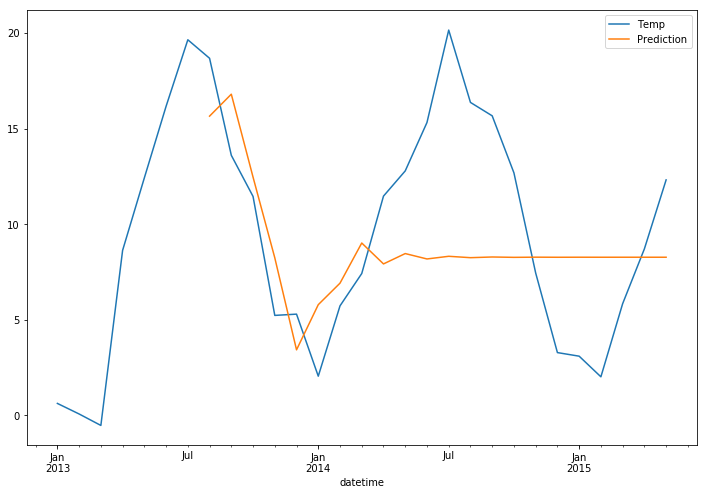

In [50]:
df.loc[:'2015-06-01'][['Temp','Prediction']].plot(figsize=(12, 8)) 

## Correlograms: ACF & PACF Plots

Verify, optimal results obtained with grid search by comparing with manual hyperparameter selection.

Picking  parameters manually using ACF/PACF plots. Art and experience required in picking good parameters from the ACF/PACF plots

Correlation is... Autocorrelation analysis to examine serial dependence

Autocorrelation is... 

PACF is .... 

https://www.datasciencecentral.com/profiles/blogs/tutorial-forecasting-with-seasonal-arima

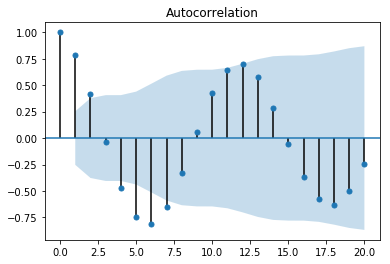

In [30]:
plot_acf(df.Temp, lags=20)
plt.show()
# ACF:  p is equal to the first lag where the PACF value is above the significance level.
# PACF: q is equal to the first lag where the ACF value is above the significance level.

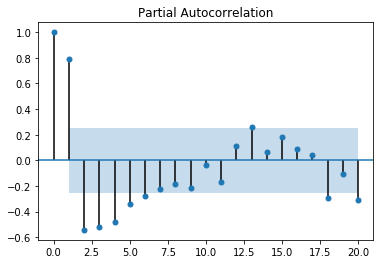

In [31]:
plot_pacf(df.Temp, lags=20)
plt.show()
# PACF: setting the value of q: 1 ,

# several lags beyond the critical boundary

## Manual hyperparameter selection using ACF / PACF Plots



Rules for SARIMA model selection from ACF/PACF plots
These are all rule of thumbs, not an exact science for picking the number of each parameters in SARIMA(p,d,q)(P,D,Q)[S]. It is an art in picking good parameters from the ACF/PACF plots. The following rules also apply to ARMA and ARIMA models.

Identifying the order of differencing:

d=0 if the series has no visible trend or ACF at all lags is low.

d≥1 if the series has visible trend or positive ACF values out to a high number of lags.

Note: if after applying differencing to the series and the ACF at lag 1 is -0.5 or more negative the series may be overdifferenced.

Note: If you find the best d to be d=1 then the original series has a constant trend. A model with d=2 assumes that the original series has a time-varying trend.

Identifying the number of AR and MA terms
p is equal to the first lag where the PACF value is above the significance level.

q is equal to the first lag where the ACF value is above the significance level.

Identifying the seasonal part of the model:

S is equal to the ACF lag with the highest value (typically at a high lag).

D=1 if the series has a stable seasonal pattern over time.

D=0 if the series has an unstable seasonal pattern over time.

Rule of thumb: d+D≤2

P≥1 if the ACF is positive at lag S, else P=0.

Q≥1 if the ACF is negative at lag S, else Q=0.

Rule of thumb: P+Q≤2

https://www.datasciencecentral.com/profiles/blogs/tutorial-forecasting-with-seasonal-arima